# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [65]:
import tensorflow
tensorflow.__version__

'2.15.0'

In [1]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.


In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [3]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [4]:
def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [5]:
file_id = '1s_fCbP8o8Z-bBTMod_n1GkIPsFWz1A8o'

download_file(file_id, 'car_images.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1s_fCbP8o8Z-bBTMod_n1GkIPsFWz1A8o
From (redirected): https://drive.google.com/uc?id=1s_fCbP8o8Z-bBTMod_n1GkIPsFWz1A8o&confirm=t&uuid=aa23e8b3-02c7-4e58-ac4c-498b75c13bc4
To: /content/car_images.zip
100%|██████████| 955M/955M [00:04<00:00, 192MB/s]


#### 2) 데이터 압축 해제

In [6]:
def dataset_extract(file_name) :
    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'./{file_name[:-4]}/') :
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        else :
            for f in tqdm(file_list, desc='Extracting', unit='files') :
                zip_ref.extract(member=f, path=f'./{file_name[:-4]}/')

In [7]:
dataset_extract('car_images.zip')

Extracting: 100%|██████████| 607/607 [00:03<00:00, 174.26files/s]


#### 2) 데이터 조회

In [8]:
# 폴더별 이미지 데이터 갯수 확인
normal_path = glob.glob('/content/car_images/normal/*.png')
abnormal_path = glob.glob('/content/car_images/abnormal/*.png')

print(f'abnormal : {len(abnormal_path)}, normal : {len(normal_path)}')

abnormal : 303, normal : 302


In [9]:
normal_path[:4], abnormal_path[:4]

(['/content/car_images/normal/DALLíñE 2023-03-10 18.52.40 - photo of a part of car.png',
  '/content/car_images/normal/DALLíñE 2023-03-11 14.25.21 - part of a car.png',
  '/content/car_images/normal/DALLíñE 2023-03-11 14.32.34 - part of a car.png',
  '/content/car_images/normal/DALLíñE 2023-03-10 22.22.18 - photo of a part of car.png'],
 ['/content/car_images/abnormal/DALLíñE 2023-03-11 00.14.28 - a part of car without scratch.png',
  '/content/car_images/abnormal/DALLíñE 2023-03-11 14.54.14 - dents of a car.png',
  '/content/car_images/abnormal/DALLíñE 2023-03-11 17.27.08 - slightly dented car.png',
  '/content/car_images/abnormal/DALLíñE 2023-03-11 01.25.20 - slightly scratched car.png'])

In [10]:
from keras.preprocessing import image

(256, 256, 3)


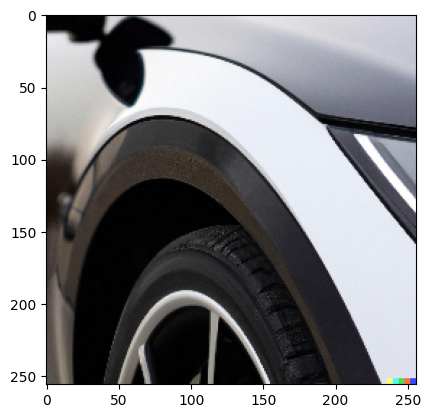

In [11]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
img = image.load_img(normal_path[np.random.randint(0,303)],target_size=(256,256))
img_array = image.img_to_array(img)
print(img_array.shape)
plt.imshow(img)
plt.show()

(256, 256, 3)


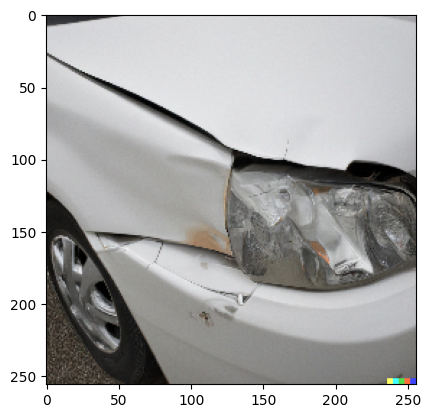

In [12]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
img = image.load_img(abnormal_path[np.random.randint(0,303)],target_size=(256,256))
img_array = image.img_to_array(img)
print(img_array.shape)
plt.imshow(img)
plt.show()

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [13]:
y = [0]*len(normal_path) + [1]*len(abnormal_path)
y = np.array(y)
len(y)

605

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [14]:
x_path_list = normal_path + abnormal_path

In [15]:
from IPython.display import clear_output

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_x, x_test_path, train_y, y_test = train_test_split(x_path_list,y,test_size=0.1, shuffle=True, random_state=53)
x_train_path, x_val_path, y_train, y_val = train_test_split(train_x,train_y,test_size=0.1,random_state=53)

In [18]:
x_train_path[:3], x_val_path[:3], x_test_path[:3]

(['/content/car_images/abnormal/DALLíñE 2023-03-11 17.10.24 - scratched car.png',
  '/content/car_images/abnormal/DALLíñE 2023-03-11 00.14.28 - a part of car without scratch.png',
  '/content/car_images/normal/DALLíñE 2023-03-11 14.44.02 - photo of part of a car.png'],
 ['/content/car_images/normal/DALLíñE 2023-03-11 14.14.14 - part of a car.png',
  '/content/car_images/normal/DALLíñE 2023-03-11 14.42.56 - photo of part of a car.png',
  '/content/car_images/normal/DALLíñE 2023-03-11 01.02.14 - photo of a part of car.png'],
 ['/content/car_images/normal/DALLíñE 2023-03-11 14.15.06 - part of a car.png',
  '/content/car_images/abnormal/DALLíñE 2023-03-11 17.15.54 - damaged car.png',
  '/content/car_images/abnormal/DALLíñE 2023-03-11 01.22.25 - scratched car.png'])

In [19]:
y_train.shape, y_val.shape, y_test.shape

((489,), (55,), (61,))

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [20]:
# x_train
x_train = []

n = 0
for path in x_train_path:
    img = image.load_img(path, target_size=(256,256))
    img = image.img_to_array(img)

    clear_output(wait=True)
    n += 1; print(f'x_train {n}/{len(x_train_path)}, x_train_len : {len(x_train)+1}' )
    x_train.append(img)

x_train = np.array(x_train)
print('x_train :', len(x_train))
print(x_train[:1])

# x_val
x_val = []

n = 0
for path in x_val_path:
    img = image.load_img(path, target_size=(256,256))
    img = image.img_to_array(img)

    clear_output(wait=True)
    n += 1; print(f'x_val {n}/{len(x_val_path)}, x_train_len : {len(x_val)+1}' )
    x_val.append(img)

x_val = np.array(x_val)
print('x_train :', len(x_val))
print(x_val[:1])

# x_test
x_test = []

n = 0
for path in x_test_path:
    img = image.load_img(path, target_size=(256,256))
    img = image.img_to_array(img)

    clear_output(wait=True)
    n += 1; print(f'x_test {n}/{len(x_test_path)}, x_train_len : {len(x_test)+1}' )
    x_test.append(img)

x_test = np.array(x_test)
print('x_train :', len(x_test))
print(x_test[:1])


x_test 61/61, x_train_len : 61
x_train : 61
[[[[161. 164. 152.]
   [160. 163. 145.]
   [154. 156. 145.]
   ...
   [133. 131. 118.]
   [130. 126. 113.]
   [138. 134. 123.]]

  [[173. 170. 163.]
   [166. 169. 152.]
   [161. 163. 150.]
   ...
   [131. 122. 112.]
   [137. 132. 119.]
   [136. 129. 109.]]

  [[148. 144. 142.]
   [178. 170. 168.]
   [180. 172. 167.]
   ...
   [135. 130. 119.]
   [132. 135. 119.]
   [134. 129. 117.]]

  ...

  [[ 44.  48.  45.]
   [ 49.  52.  47.]
   [ 50.  51.  51.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]

  [[ 49.  52.  46.]
   [ 45.  46.  42.]
   [ 44.  45.  43.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]

  [[ 46.  45.  41.]
   [ 48.  46.  43.]
   [ 42.  43.  40.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]]]


In [21]:
x_train.shape, x_val.shape, x_test.shape

((489, 256, 256, 3), (55, 256, 256, 3), (61, 256, 256, 3))

In [22]:
# x를 minmax scale
# layer에서

# min_n, max_n = x_train.min(), x_train.max()

# x_train = (x_train - min_n) / (max_n - min_n)
# x_val = (x_val - min_n) / (max_n - min_n)
# x_test = (x_test - min_n) / (max_n - min_n)

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [23]:
import keras
from keras.utils import clear_session

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, Input, MaxPool2D
from keras.layers import RandomBrightness, RandomRotation, RandomZoom, Rescaling, RandomTranslation
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import *


#### 1) 구조 설계

In [61]:
clear_session()

# 모델 선언
model1 = Sequential()

model1.add(Input(shape=(256,256,3)))

# minmax_scaler
# model1.add(Rescaling(scale=1/255))

# agmentation
# model1.add(RandomBrightness(factor=(-0.01,0.01)))

model1.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,027,585 (22.99 MB)

 Trainable params: 6,027,585 (22.99 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model1.compile(optimizer=Adam(0.001), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', # 학습률 동적 조절
                                 patience=4,
                                 verbose=1,
                                 factor=0.1,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=10,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   verbose=1,
                   restore_best_weights=True) # best 가중치 저장

mcp = ModelCheckpoint(filepath='./bestmodel1.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 .h5 | False : 모델 구조 포함하여 저장 .keras

#### 2) 학습

In [63]:
model1.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=1000, callbacks=[lr_reduction, es, mcp], batch_size=64)

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5207 - loss: 36.5843
Epoch 1: val_loss improved from inf to 0.96655, saving model to ./bestmodel1.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - accuracy: 0.5183 - loss: 35.3179 - val_accuracy: 0.4545 - val_loss: 0.9666 - learning_rate: 0.0010
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5206 - loss: 0.7840
Epoch 2: val_loss improved from 0.96655 to 0.68565, saving model to ./bestmodel1.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.5232 - loss: 0.7777 - val_accuracy: 0.5273 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6091 - loss: 0.6612
Epoch 3: val_loss improved from 0.68565 to 0.59386, saving model to ./bestmodel1.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.6073 - loss: 0.6616 - val_accuracy: 0.6909 - val_loss: 0.5939 - learning_rate: 0.0010
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [60]:
pred = model1.predict(x_test)
pred = np.where(pred >= 0.5, 1, 0)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
[[12 16]
 [ 8 25]]
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        28
           1       0.61      0.76      0.68        33

    accuracy                           0.61        61
   macro avg       0.60      0.59      0.59        61
weighted avg       0.61      0.61      0.60        61



In [ ]:
model1.save

### (2) 모델 2
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [31]:
import keras
from keras.utils import clear_session

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, Input, MaxPool2D
from keras.layers import RandomBrightness, RandomRotation, RandomZoom, Rescaling, RandomTranslation
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import *


#### 1) 구조 설계

In [ ]:
clear_session()

# 모델 선언
model2 = Sequential()

model2.add(Input(shape=(256,256,3)))

# minmax_scaler
# model2.add(Rescaling(scale=1/255))

# agmentation
# model1.add(RandomBrightness(factor=(-0.01,0.01)))

model2.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      51,381,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,770,689 (197.49 MB)

 Trainable params: 51,770,689 (197.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer=Adam(0.0001), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', # 학습률 동적 조절
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=9,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   verbose=1,
                   restore_best_weights=True) # best 가중치 저장

mcp = ModelCheckpoint(filepath='./bestmodel1.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 .h5 | False : 모델 구조 포함하여 저장 .keras

#### 2) 학습

In [ ]:
model2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=1000, callbacks=[lr_reduction, es, mcp])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5362 - loss: 1.5088
Epoch 1: val_loss improved from inf to 0.69183, saving model to ./bestmodel1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.5341 - loss: 1.4841 - val_accuracy: 0.4727 - val_loss: 0.6918 - learning_rate: 1.0000e-04
Epoch 2/1000
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4059 - loss: 0.6993
Epoch 2: val_loss improved from 0.69183 to 0.69007, saving model to ./bestmodel1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.4109 - loss: 0.6995 - val_accuracy: 0.8182 - val_loss: 0.6901 - learning_rate: 1.0000e-04
Epoch 3/1000
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5639 - loss: 0.6908
Epoch 3: val_loss improved from 0.69007 to 0.68584, saving model to ./bestmodel1.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5609 - loss: 0.6911 - val_accuracy: 0.7818 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 4/1000
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
pred = model2.predict(x_test)
pred = np.where(pred >= 0.5, 1, 0)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
[[27  6]
 [18 10]]
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        33
           1       0.62      0.36      0.45        28

    accuracy                           0.61        61
   macro avg       0.61      0.59      0.57        61
weighted avg       0.61      0.61      0.58        61



## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

In [23]:
from keras.utils import image_dataset_from_directory
from keras.layers import Rescaling
import shutil
import os

In [21]:
# 이미지 data 복사 이동
image_path = '/content/car_images/'
copy_path = '/content/car_images2/train/'

for folder in ['normal','abnormal']:
    folder_path = image_path + folder
    save_path = copy_path + folder

    if os.path.exists(folder_path):  # 파일이 존재하는 경우에만 이동
        os.makedirs(copy_path, exist_ok=True) # 폴더가 없는경우 생성
        shutil.copytree(folder_path, save_path) # folder_path의 폴더를 save_path로 복사

FileExistsError: [Errno 17] File exists: '/content/car_images2/train/normal'

In [24]:
# 전제 : x_target_path에 test images set의 경로가 리스트로 담겨있다

# 원본 보존을 위해 이미지를 car_images2의 train 폴더에 복사
# image_path = '/content/car_images/'
# copy_path = '/content/car_images2/train/'

# for folder in ['normal','abnormal']:
#     folder_path = image_path + folder
#     save_path = copy_path + folder

#     if os.path.exists(folder_path):  # 파일이 존재하는 경우에만 이동
#         os.makedirs(copy_path, exist_ok=True) # 폴더가 없는경우 생성
#         shutil.copytree(folder_path, save_path) # folder_path의 폴더를 save_path로 복사

#test set이미지 test 폴더로 이동
for folder in ['normal','abnormal']:
    for path in x_test_path:
        save_path = '/content/car_images2/test/'+folder

        file_name = path.split('/')[-1]
        if os.path.exists(f'/content/car_images2/train/{folder}/{file_name}'):  # 파일이 존재하는 경우에만 이동
            os.makedirs(save_path, exist_ok=True) # 폴더가 없는경우 생성
            shutil.move(f'/content/car_images2/train/{folder}/{file_name}', save_path) # file_path의 파일을 save_path로 이동



# image_dataset_from_directory 선언
train_ds = image_dataset_from_directory(
    '/content/car_images2/train/',
    image_size=(256, 256),  # 이미지 크기 설정
    batch_size=64,           # 배치 크기 설정
    validation_split=0.2,    # 검증 데이터셋 분할 비율
    subset='training',       # 'training' 또는 'validation' 중 선택
    label_mode='int',       # 라벨 형식 설정
    class_names=['normal', 'abnormal'],  # 라벨 순서
    seed=42)

val_ds = image_dataset_from_directory(
    '/content/car_images2/train/',
    image_size=(256, 256),
    batch_size=64,
    validation_split=0.2,
    subset='validation',
    label_mode='int',
    class_names=['normal', 'abnormal'],
    seed=42)



# test set array로 불러오기
# test_set path
test_normal = glob.glob('/content/car_images2/test/normal/*.png')
test_abnormal = glob.glob('/content/car_images2/test/abnormal/*.png')

# target 값 생성
y_test = [0]*len(test_normal) + [1]*len(test_abnormal)

# 이미지 array로 불러오기
test_path = test_normal + test_abnormal
x_test = []

n = 0
for path in test_path:
    img = image.load_img(path, target_size=(256,256))
    img = image.img_to_array(img)

    clear_output(wait=True)
    n += 1; print(f'x_test {n}/{len(test_path)}, x_train_len : {len(x_test)+1}' )
    x_test.append(img)

x_test = np.array(x_test)
print('x_train :', len(x_test))
print(x_test[:1])

x_test 61/61, x_train_len : 61
x_train : 61
[[[[161. 164. 152.]
   [160. 163. 145.]
   [154. 156. 145.]
   ...
   [133. 131. 118.]
   [130. 126. 113.]
   [138. 134. 123.]]

  [[173. 170. 163.]
   [166. 169. 152.]
   [161. 163. 150.]
   ...
   [131. 122. 112.]
   [137. 132. 119.]
   [136. 129. 109.]]

  [[148. 144. 142.]
   [178. 170. 168.]
   [180. 172. 167.]
   ...
   [135. 130. 119.]
   [132. 135. 119.]
   [134. 129. 117.]]

  ...

  [[ 44.  48.  45.]
   [ 49.  52.  47.]
   [ 50.  51.  51.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]

  [[ 49.  52.  46.]
   [ 45.  46.  42.]
   [ 44.  45.  43.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]

  [[ 46.  45.  41.]
   [ 48.  46.  43.]
   [ 42.  43.  40.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]]]


In [25]:
#test set을 train 폴더에서 이동 파일 이 folder
print('이동 전')
print('train normal :', len(glob.glob('/content/car_images2/train/normal/*.png')))
print('train abnormal :', len(glob.glob('/content/car_images2/train/abnormal/*.png')))

for folder in ['normal','abnormal']:
    for path in x_test_path:
        save_path = '/content/car_images2/test/'+folder

        file_name = path.split('/')[-1]
        if os.path.exists(f'/content/car_images2/train/{folder}/{file_name}'):  # 파일이 존재하는 경우에만 이동
            os.makedirs(save_path, exist_ok=True) # 폴더가 없는경우 생성
            shutil.move(f'/content/car_images2/train/{folder}/{file_name}', save_path) # file_path의 파일을 save_path로 이동

print('이동 후')
print('train normal :', len(glob.glob('/content/car_images2/train/normal/*.png')))
print('train abnormal :', len(glob.glob('/content/car_images2/train/abnormal/*.png')))
print('test normal :', len(glob.glob('/content/car_images2/test/normal/*.png')))
print('test abnormal :', len(glob.glob('/content/car_images2/test/abnormal/*.png')))


이동 전
train normal : 274
train abnormal : 270
이동 후
train normal : 274
train abnormal : 270
test normal : 28
test abnormal : 33


In [26]:
# image_dataset_from_directory 선언

train_ds = image_dataset_from_directory(
    '/content/car_images2/train/',
    image_size=(256, 256),  # 이미지 크기 설정
    batch_size=64,           # 배치 크기 설정
    validation_split=0.2,    # 검증 데이터셋 분할 비율
    subset='training',       # 'training' 또는 'validation' 중 선택
    label_mode='int',       # 라벨 형식 설정
    class_names=['normal', 'abnormal'],  # 라벨 순서
    seed=53)

val_ds = image_dataset_from_directory(
    '/content/car_images2/train/',
    image_size=(256, 256),
    batch_size=64,
    validation_split=0.2,
    subset='validation',
    label_mode='int',
    class_names=['normal', 'abnormal'],
    seed=53)

Found 544 files belonging to 2 classes.
Using 436 files for training.
Found 544 files belonging to 2 classes.
Using 108 files for validation.


In [27]:
# test_set path
test_normal = glob.glob('/content/car_images2/test/normal/*.png')
test_abnormal = glob.glob('/content/car_images2/test/abnormal/*.png')

# target 값 생성
y_test = [0]*len(test_normal) + [1]*len(test_abnormal)

# 이미지 array로 불러오기
test_path = test_normal + test_abnormal
x_test = []

n = 0
for path in test_path:
    img = image.load_img(path, target_size=(256,256))
    img = image.img_to_array(img)

    clear_output(wait=True)
    n += 1; print(f'x_test {n}/{len(test_path)}, x_train_len : {len(x_test)+1}' )
    x_test.append(img)

x_test = np.array(x_test)
print('x_train :', len(x_test))
print(x_test[:1])


x_test 61/61, x_train_len : 61
x_train : 61
[[[[161. 164. 152.]
   [160. 163. 145.]
   [154. 156. 145.]
   ...
   [133. 131. 118.]
   [130. 126. 113.]
   [138. 134. 123.]]

  [[173. 170. 163.]
   [166. 169. 152.]
   [161. 163. 150.]
   ...
   [131. 122. 112.]
   [137. 132. 119.]
   [136. 129. 109.]]

  [[148. 144. 142.]
   [178. 170. 168.]
   [180. 172. 167.]
   ...
   [135. 130. 119.]
   [132. 135. 119.]
   [134. 129. 117.]]

  ...

  [[ 44.  48.  45.]
   [ 49.  52.  47.]
   [ 50.  51.  51.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]

  [[ 49.  52.  46.]
   [ 45.  46.  42.]
   [ 44.  45.  43.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]

  [[ 46.  45.  41.]
   [ 48.  46.  43.]
   [ 42.  43.  40.]
   ...
   [ 60.  70. 255.]
   [ 60.  70. 255.]
   [ 60.  70. 255.]]]]


### (2) Transfer Learning

In [ ]:
from keras.applications import InceptionV3

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [ ]:
base_model = InceptionV3(include_top=False,
                         weights='imagenet',
                         pooling='avg')

for layer in base_model.layers:
    layer.trainable = False

#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

In [ ]:
clear_session()

il = Input(shape=(256,256,3))

ag1 = RandomTranslation(0.1,0.1)(il)
ag2 = RandomZoom(0.1,0.1)(ag1)
ag3 = RandomRotation(0.1)(ag2)

rs = Rescaling(scale=1/255)(ag3)

bm = base_model(rs)

# hl1 = Dense(2048, activation='relu')(bm)
ol = Dense(1, activation='sigmoid')(bm)

model3 = Model(il,ol)

model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 256, 256, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model3.compile(optimizer=Adam(0.001), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', # 학습률 동적 조절
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=6,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   verbose=1,
                   restore_best_weights=True) # best 가중치 저장

mcp = ModelCheckpoint(filepath='./bestmodel3.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 .h5 | False : 모델 구조 포함하여 저장 .keras

#### 3) 학습

In [ ]:
model3.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[lr_reduction, es, mcp])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.5706 - loss: 0.6645
Epoch 1: val_loss improved from inf to 0.52641, saving model to ./bestmodel3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5770 - loss: 0.6602 - val_accuracy: 0.7870 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8016 - loss: 0.4892
Epoch 2: val_loss improved from 0.52641 to 0.42491, saving model to ./bestmodel3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 524ms/step - accuracy: 0.8038 - loss: 0.4864 - val_accuracy: 0.8519 - val_loss: 0.4249 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8558 - loss: 0.3875
Epoch 3: val_loss improved from 0.42491 to 0.36248, saving model to ./bestmodel3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.8558 - loss: 0.3871 - val_accuracy: 0.8796 - val_loss: 0.3625 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8864 - l

#### 4) 성능 평가

In [ ]:
pred = model3.predict(x_test)
pred = np.where(pred >= 0.54, 1, 0)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[[26  2]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.94      0.97      0.96        33

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



In [ ]:
for layer in model3.layers:
    layer.trainable = False

model3.layers[-1] = True
model3.layers[-2] = True

In [ ]:
model3.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[lr_reduction, es, mcp])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9995 - loss: 0.0109
Epoch 1: val_loss did not improve from 0.65947
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.9994 - loss: 0.0111 - val_accuracy: 0.8796 - val_loss: 1.5163 - learning_rate: 5.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9997 - loss: 0.0040
Epoch 2: val_loss improved from 0.65947 to 0.62127, saving model to ./bestmodel3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 497ms/step - accuracy: 0.9995 - loss: 0.0041 - val_accuracy: 0.9074 - val_loss: 0.6213 - learning_rate: 5.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 1.0000 - loss: 0.0074
Epoch 3: val_loss improved from 0.62127 to 0.43542, saving model to ./bestmodel3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 501ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.8981 - val_loss: 0.4354 - learning_rate: 5.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 1.0000 - loss: 0.0

In [ ]:
pred = model3.predict(x_test)
pred = np.where(pred >= 0.5, 1, 0)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
[[28  0]
 [ 3 30]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       1.00      0.91      0.95        33

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.96      0.95      0.95        61



### (3) Transfer Learning2

In [28]:
from keras.applications import VGG19

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [29]:
base_model = VGG19(include_top=False,
                         weights='imagenet',
                         pooling='avg')

for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

In [51]:
clear_session()

il = Input(shape=(256,256,3))

ag1 = RandomTranslation(0.1,0.1)(il)
ag2 = RandomZoom(0.1,0.1)(ag1)
ag3 = RandomRotation(0.1)(ag2)

rs = Rescaling(scale=1/255)(ag3)

bm = base_model(rs)

# hl1 = Dense(2048, activation='relu')(bm)
ol = Dense(1, activation='sigmoid')(bm)

model3 = Model(il,ol)

model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 256, 256, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,897 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [53]:
model3.compile(optimizer=Adam(0.01), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', # 학습률 동적 조절
                                 patience=4,
                                 verbose=1,
                                 factor=0.1,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=10,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   verbose=1,
                   restore_best_weights=True) # best 가중치 저장

mcp = ModelCheckpoint(filepath='./bestmodel3.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 .h5 | False : 모델 구조 포함하여 저장 .keras

#### 3) 학습

In [54]:
model3.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[lr_reduction, es, mcp])

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5540 - loss: 0.6824
Epoch 1: val_loss improved from inf to 0.76432, saving model to ./bestmodel3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 761ms/step - accuracy: 0.5556 - loss: 0.6820 - val_accuracy: 0.3981 - val_loss: 0.7643 - learning_rate: 0.0100
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5514 - loss: 0.6785
Epoch 2: val_loss improved from 0.76432 to 0.51673, saving model to ./bestmodel3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - accuracy: 0.5648 - loss: 0.6702 - val_accuracy: 0.7963 - val_loss: 0.5167 - learning_rate: 0.0100
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8000 - loss: 0.5529
Epoch 3: val_loss improved from 0.51673 to 0.49263, saving model to ./bestmodel3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - accuracy: 0.8023 - loss: 0.5510 - val_accuracy: 0.7963 - val_loss: 0.4926 - learning_rate: 0.0100
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.80

#### 4) 성능 평가

In [70]:
pred = model3.predict(x_test)
pred = np.where(pred >= 0.5, 1, 0)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
[[26  2]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.94      0.97      0.96        33

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



In [35]:
pred = model3.predict(x_test)
pred = np.where(pred >= 0.5, 1, 0)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
[[26  2]
 [ 5 28]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.93      0.85      0.89        33

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



In [71]:
clear_session()

il = Input(shape=(256,256,3))

ag1 = RandomTranslation(0.1,0.1)(il)
ag2 = RandomZoom(0.1,0.1)(ag1)
ag3 = RandomRotation(0.1)(ag2)

bm = base_model(ag3)

# hl1 = Dense(2048, activation='relu')(bm)
ol = Dense(1, activation='sigmoid')(bm)

model4 = Model(il,ol)

model4.summary()

model4.compile(optimizer=Adam(0.01), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', # 학습률 동적 조절
                                 patience=4,
                                 verbose=1,
                                 factor=0.1,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=10,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   verbose=1,
                   restore_best_weights=True) # best 가중치 저장

mcp = ModelCheckpoint(filepath='./bestmodel3.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 .h5 | False : 모델 구조 포함하여 저장 .keras


model4.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[lr_reduction, es, mcp])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 256, 256, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,897 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6047 - loss: 1.5894
Epoch 1: val_loss improved from inf to 0.59765, saving model to ./bestmodel3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 742ms/step - accuracy: 0.6117 - loss: 1.5548 - val_accuracy: 0.7963 - val_loss: 0.5976 - learning_rate: 0.0100
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8198 - loss: 0.5342
Epoch 2: val_loss did not improve from 0.59765
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.8211 - loss: 0.5300 - val_accuracy: 0.8056 - val_loss: 0.8377 - learning_rate: 0.0100
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8311 - loss: 0.4054
Epoch 3: val_loss did not improve from 0.59765
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 640ms/step - accuracy: 0.8333 - loss: 0.4018 - val_accuracy: 0.8519 - val_loss: 0.6037 - learning_rate: 0.0100
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9133 - loss: 0.2550
Epoch 4: val_loss improved from 0.59765 to 0.44259, saving mod

In [78]:
pred = model4.predict(x_test)
pred = np.where(pred >= 0.5, 1, 0)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
[[27  1]
 [ 1 32]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.97      0.97      0.97        33

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61

